In [14]:
import numpy as np
import matplotlib.pyplot as plt

import activation_functions as af
from util.cifar10_loader import Cifar10Loader
from util.data_visualizer import DataVisualizer
%matplotlib inline

### Concepts:
- Neural networks are universal approximators - neural networks with 1 hidden layer can approximate to
  any continuous function
- In practice, it has been observed that 3 layer NNs outperform 2 layer NNs but adding more depth does not help. 
  But this is not the case with CNNs where depth has been found to be extremely important component for a good
  recognition system (on order of 10 layers) - probably because images contain hierarchy.

#### Weights and Bias
- Weights: should have a variance of c/n where n is the number of features (inputs). So initialize it to:
      w = np.random.randn(n) * np.sqrt(1/n)  for non-ReLU units
      w = np.random.randn(n) * np.sqrt(2/n)  for ReLU units
  where randn samples from a gaussian (normal) of mean=0, standard deviation=1.
- Bias: initialize it to 0.

#### Overfitting:
- occurs when a model with high capacity (or complexity or many parameters) fits to the noise in 
  data instead of the assumed underlying relationship.
- there are many preferred ways to prevent overfitting - such as L2 regularization, dropout, input noise. 
  In practice, it is always better to use these methods to control overfitting instead of the number of neurons.
- Therefore, regularization strength is the preferred way to control overfitting.
- Smaller networks are harder to train with local methods such as Gradient Descent: It’s clear that their loss       functions have relatively few local minima, but it turns out that many of these minima are easier to converge to,   and that they are bad (i.e. with high loss). Conversely, bigger neural networks contain significantly more local   minima, but these minima turn out to be much better in terms of their actual loss. Since Neural Networks are non-   convex, it is hard to study these properties mathematically. In practice, what you find is that if you train a     small network the final loss can display a good amount of variance - in some cases you get lucky and converge to   a good place but in some cases you get trapped in one of the bad minima. On the other hand, if you train a large   network you’ll start to find many different solutions, but the variance in the final achieved loss will be much     smaller. In other words, all solutions are about equally as good, and rely less on the luck of random               initialization.
- The takeaway is that you should not be using smaller networks because you are afraid of overfitting. Instead, you   should use as big of a neural network as your computational budget allows, and use other regularization             techniques to control overfitting.
- L2 regularization (most preferred): 
        Loss += 0.5 * lambda * W * W
        W += -lambda * W
- L1 regularization:
        Loss += lambda * abs(W)
        W += -lambda is W > 0, else lambda
- Max norm:
  - After doing weight updation, clamp the weight vector of every neuron to satisfy l2-norm(W) < c. 
  - c is usually 3 or 4.
- Dropout (to be used in complement to the above methods):
  - Keeping a neuron active with some probabililty p (hyper parameter), else setting it to 0.
  - Interpretation: Sampling a neural network within a full neural network and updating the parameters of the
    sampled network based on the input data.
  - During testing, dropout is not considered.
  - Example implementation:
        p = probability of keeping a unit active (higher value implies lower dropout)
        H = relu(np.dot(X.W) + B)
        U = (np.random.rand(*H.shape) < p)
        H *= U / p

#### Batch Normalization:
- Force the activations throughout a network to get unit gaussian (normalized) data. This is achieved by having
  a batch normalization layer in between the fully connected layer and the activation layer.
- This is a widely used technique and makes the network robust against bad initializations.


#### Output - Classification:
- Use SVM (loss = hinge/squared hinge), Softmax (loss=cross entropy), sigmoid as activation for the last layer.
- For cases with large number of classes: use hierarchical softmax
- In some scenarios where the input maps to multiple labels, it may make sense to divide the problem into multiple
  binary classification problems.

#### Output - Regression:
- Loss is L2 or L1 norm of (Y_predicted - Y). L2 is preferred.
- L2 loss is much harder to optimize as compared to say Softmax. Hence, try hard to convert the regression problem
  into a classification problem - discretize output into bins. Ex: Ratings from 1 to 5 can be considered as a classification problem with 5
  outputs.

#### TODO:
- Implement SVM, Softmaxx, Logistic as single layer NN
- perceptrons?
- Go back to classifiers and change weight initializations to suggested above.
- Try PCA for other classifiers.

In [178]:
model_path = './models'
data_loader = Cifar10Loader()
dv = DataVisualizer()

X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar, labels = data_loader.load_cifar10('./Datasets/cifar-10')

# Flatten data
X_train_cifar = X_train_cifar.reshape(X_train_cifar.shape[0], -1)
X_test_cifar = X_test_cifar.reshape(X_test_cifar.shape[0], -1)
X_train_cifar, y_train_cifar, X_val_cifar, y_val_cifar = shuffle_and_split(X_train_cifar, y_train_cifar, split=0.8)

## Data Preprocessing

- For CNNs: PCA and whitening is never done. Zero Centre (mean subtraction) and Normalization is done though.
- For other classifications: PCA and whitening may help. Also, reduces computation. Normalization is not done then.

### Preprocess data Way 1

In [179]:
def scale_features(X, X_mean=None, X_std=None, divide_by_std_dev=True, view_plots=False):
    if X_mean is None:
        X_mean = np.mean(X, axis=0)
    if X_std is None:
        X_std = np.std(X, axis=0)
    X_1 = X - X_mean
    X_2 = X_1/X_std

    if view_plots == True:
        fig, axes1 = plt.subplots(3,1,figsize=(20,20))
        plt.suptitle('Histogram of 0th pixel of all examples')
        axes1[0].set_aspect('equal')
        axes1[0].set_title('data')
        axes1[0].scatter(X[:,0], X[:,1], marker='o')
        axes1[0].set_xlim([-2, 2])
        axes1[0].set_ylim([-2, 2])
        axes1[1].set_aspect('equal')        
        axes1[1].set_title('data - Mean(data)')
        axes1[1].scatter(X_1[:,0], X_1[:,1])        
        axes1[1].set_xlim([-2, 2])
        axes1[1].set_ylim([-2, 2])
        axes1[2].set_aspect('equal')        
        axes1[2].set_title('(data - Mean(data))/Std_dev(data)')
        axes1[2].scatter(X_2[:,0], X_2[:,1])        
        axes1[2].set_xlim([-2, 2])
        axes1[2].set_ylim([-2, 2])

    if divide_by_std_dev is True:
        return X_2, X_mean, X_std
    else:
        return X_1, X_mean, X_std

def shuffle_and_split(X, y, split=0.8):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    X_train = X[indexes[:int(split*X.shape[0])]]
    y_train = y[indexes[:int(split*X.shape[0])]]    
    X_val = X[indexes[int(split*X.shape[0]):]]
    y_val = y[indexes[int(split*X.shape[0]):]]    
    return X_train, y_train, X_val, y_val

In [180]:
X_train, X_mean, X_std = scale_features(X_train_cifar)
X_val = scale_features(X_val_cifar, X_mean=X_mean, X_std=X_std)
X_test = scale_features(X_test_cifar, X_mean=X_mean, X_std=X_std)
y_train, y_val, y_test = y_train_cifar, y_val_cifar, y_test_cifar

### Preprocess data Way 2

In [172]:
def reduce_dimension_by_pca(X_input, reduced_dimensions=200, enable_whitening=True):
    # Variance of feature i = normalized sum across all examples of: (Xij - Xi_mean)^2 for example j
    # By zero centering, Xi_mean = 0
    X = X_input - np.mean(X_input, axis=0)

    # covariance = E(X.T, X)  where E is expected
    # Due to zero centering covariance becomes:
    cov = np.dot(X.T, X)

    # cov is a symmetric matrix (hence square) with diagonal elements having variance of ith feature 
    # and other elements having variance between i, j features.
    # Any matrix of the form dot(v.T, v) where v is a real valued random variable becomes a 
    # Positive Semi-definite matrix.
    # A Positive semi-definite matrix M is one which satisfies the condition (x.T).M.x >= 0 for all x vectors.

    # The covariance matrix is a positive semi-definite matrix (and hence a symmetric), 
    # Hence, we can use eigendecomposition to generate the eigenvalues and eigenvectors.
    # All the eigenvalues should be positive
    eigen_values, eigen_vectors = np.linalg.eig(cov)
    eigen_values_ind = np.argsort(eigen_values)[::-1] #sort in descending order
    e_values  = eigen_values[eigen_values_ind]
    e_vectors = eigen_vectors[:, eigen_values_ind]

    # A more generalized technique is to use to Singular Value Decomposition (SVD).
    # e_vectors_T is almost the transpose of e_vectors
    # linalg.svd() returns vectors and values sorted by the eigenvalues, hence further sorting is not needed as above.
    # e_vectors, e_values, e_vectors_T = np.linalg.svd(cov)
    
    # e_vectors are a set of orthonormal vectors (basis). So on projecting X onto this basis, X gets rotated 
    # such that its new axis is the e_vectors.
    # e_values are variance across the e_vectors.
    # X_rot = np.dot(X, e_vectors)
    # Covariance matrix of X_rot has e_values in diagonal and 0's in other locations.

    # We reduce the dimensionality of the data by considering only first few dimensions
    X_pca = np.dot(X, e_vectors[:, :reduced_dimensions])
    print("Dimensions reduced from {} to {}".format(X.shape, X_pca.shape))
    
    if enable_whitening is True:
        # Whitening - divide by sqrt(eigenvalue) (similar to dividing by std!).
        # covariance of X_train_whitened_reduced will be identity matrix.         
        X_pca = X_pca/np.sqrt(e_values[:reduced_dimensions])
    return X_pca, e_values, e_vectors

def regenerate_image(X_pca, e_vectors):
    num_reduced_dimensions = X_pca.shape[1]
    return np.dot(X_pca, e_vectors[:, :num_reduced_dimensions].T)

In [163]:
X_pca, e_values, e_vectors = reduce_dimension_by_pca(X_train_cifar)

Dimensions reduced from (40000, 3072) to (40000, 200)


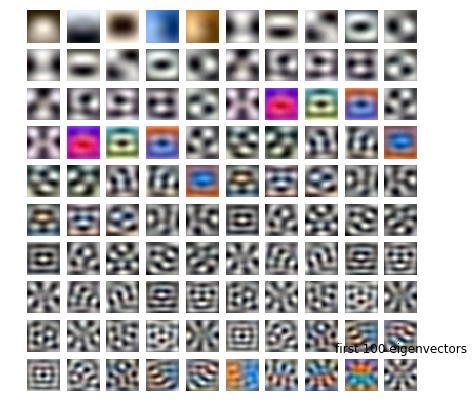

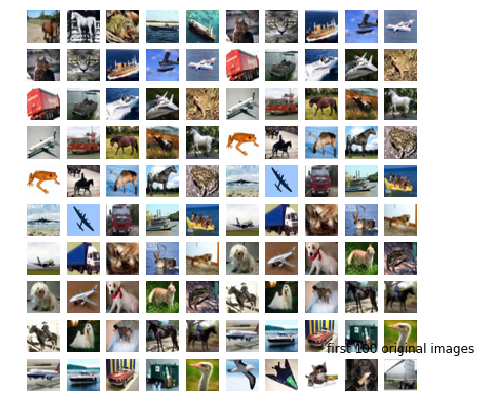

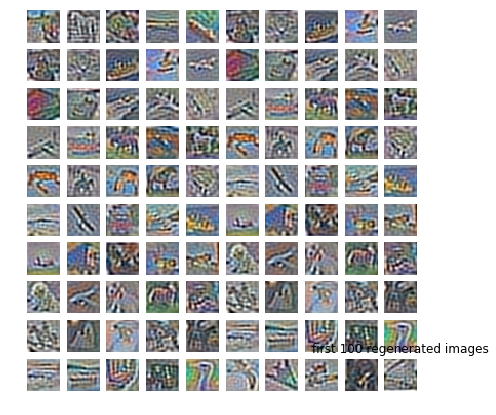

In [171]:
# Plot first 100 eigenvectors
plot_grid(e_vectors.T, vplots=10, hplots=10, title='first 100 eigenvectors')

# Plot first 100 actual images
plot_grid(X_train_cifar, vplots=10, hplots=10, title='first 100 original images')

# Plot first 100 regenerated images
plot_grid(regenerate_image(X_pca, e_vectors), vplots=10, hplots=10, title='first 100 regenerated images')

In [170]:
def plot_grid(X, vplots=10, hplots=10, title='First 100 images'):
    fig, axes1 = plt.subplots(vplots,hplots, figsize=(7,7))
    plt.title(title)
    for j in range(vplots):
        for k in range(hplots):
            i = j*5 + k
            vector = X[i]
            vector_min = np.min(vector)
            vector_max = np.max(vector)
            vector_0_1 = (vector - vector_min)/(vector_max - vector_min)        
            axes1[j][k].set_axis_off()
            im = axes1[j][k].imshow(vector_0_1.reshape(32,32,3))

In [218]:
class NeuralNetwork():
    def __init__(self):
        self.num_input_nodes = 0
        self.num_output_nodes = 0        
        self.num_layers = 0
        self.num_nodes = {}
        self.w = {}
        self.b = {}
        self.act_func = {}
        self.d_act_func = {}
        pass
    
    def _set_activation_functions(self, activation):
        if activation == 'relu':
            self.act_func[self.num_layers] = af.ReLU
            self.d_act_func[self.num_layers] = af.d_ReLU
        elif activation == 'sigmoid':
            self.act_func[self.num_layers] = af.sigmoid
            self.d_act_func[self.num_layers] = af.d_sigmoid
        elif activation == 'tanh':
            self.act_func[self.num_layers] = af.tanh
            self.d_act_func[self.num_layers] = af.d_tanh
        elif activation == 'leaky_relu':
            self.act_func[self.num_layers] = af.leaky_ReLU
            self.d_act_func[self.num_layers] = af.d_leaky_ReLU
#         elif activation == 'softmax':
#             self.act_func[self.num_layers] = af.softmax
#             self.d_act_func[self.num_layers] = af.d_softmax
#         elif activation == 'svm':
#             self.act_func[self.num_layers] = af.svm
#             self.d_act_func[self.num_layers] = af.d_svm
            
            
    def add(self, num_nodes, activation='relu', num_input_features=None):
        if self.num_input_nodes != 0 and num_input_features != None:
            raise ValueError("Number of Input features already provided. Need to provide only for first layer.")
        if num_input_features != None:
            self.num_input_nodes = num_input_features
            self.num_nodes[0] = num_input_features
        self._set_activation_functions(activation)
        self.num_layers += 1
        self.num_nodes[self.num_layers] = num_nodes

    def _initialize_weights_and_bias(self):
        for i in range(self.num_layers):
            self.w[i] = np.random.randn(self.num_nodes[i], self.num_nodes[i+1]) * np.sqrt(2/self.num_nodes[0])
            self.b[i] = np.zeros((self.num_nodes[i+1], 1), dtype=float)
            
    def _one_hot_encode(self, y):
        y_ohe = np.zeros((y.shape[0], self.num_output_nodes), dtype=int)
        y_ohe[:, y_train] = 1
        return y_ohe
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        X = X_train
        self.num_output_nodes = self.num_nodes[self.num_layers]
        self.num_train_data = X.shape[0]

        if X.shape[1] != self.num_input_nodes or np.unique(y_train).shape[0] != self.num_output_nodes:
            raise ValueError("Something wrong with Input Values")

        y = self._one_hot_encode(y_train)
        
        self._initialize_weights_and_bias()
        
        

In [219]:
nn = NeuralNetwork()
nn.add(num_nodes=100, activation='relu', num_input_features=X_train.shape[1])
nn.add(num_nodes=10, activation='softmax')
nn.fit(X_train, y_train, X_val, y_val)

In [225]:
nn.num_layers, nn.num_nodes
nn.b[0].shape, nn.b[1].shape

((100, 1), (10, 1))

## Neural Networks

In [183]:

num_classes = np.unique(y_train).shape[0]
num_output_nodes = num_classes
num_input_nodes = num_features
# num_hidden_nodes

# Need to convert y_train to one hot encoding
y = np.zeros((y_train.shape[0], num_output_nodes), dtype=int)
y[:, y_train] = 1

w1 = np.random.randn(num_input_nodes, num_output_nodes) * sqrt(2/num_features)
b1 = 

h1 = act_func(np.dot(X, w1) + b1)



10


In [210]:
a = np.ones((2, ))
b = np.ones((2, 1))
a.shape, b.shape
b.shape[1] > 1

False